In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [5]:
data = pd.read_csv('processed_train.csv')
data.head()

,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,...,Platform_windows8,Processor_x64,Processor_x86,Census_DeviceFamily_Windows.Server,Census_OSArchitecture_arm64,Census_OSArchitecture_x86,Census_GenuineStateName_IS_GENUINE,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN,HasDetections
0,0.552153,0.530941,0.587952,7.0,0,53447.0,1.0,1.0,1,29,...,0,1,0,0,0,0,1,0,0,0
1,0.448751,0.528931,0.484434,7.0,0,53447.0,1.0,1.0,1,93,...,0,1,0,0,0,0,0,1,0,0
2,0.552153,0.530941,0.557522,7.0,0,53447.0,1.0,1.0,1,86,...,0,1,0,0,0,0,1,0,0,0
3,0.552153,0.530941,0.482759,7.0,0,53447.0,1.0,1.0,1,97,...,0,1,0,0,0,0,1,0,0,0
4,0.493175,0.530941,0.505721,7.0,0,53447.0,1.0,1.0,1,164,...,0,1,0,0,0,0,1,0,0,0


Разобьем выборку на тест и трейн

In [6]:
from sklearn.model_selection import train_test_split

X = data.drop('HasDetections', axis=1)
y = data['HasDetections']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=33)

Обучите LogReg и SVM с помощью классов `LogisticRegression` и `LinearSVC`. Добавьте шаг стандартизации данных в пайплайны. Для разнообразия, возьмем `MinMaxScaler`. Пайплайны запишем в переменные `pipe_lr` и `pipe_svm` соответственно!

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler

### Your code is here
# логистическая регрессия

pipe_lr = Pipeline([('scaler', MinMaxScaler()), ('LR', LogisticRegression())])
pipe_lr.fit(X_train, y_train)

# accuracy для LogReg
print(f"Accuracy for LogReg: {pipe_lr.score(X_test, y_test):.3f}")


Accuracy for LogReg: 0.843


In [18]:
pipe_svm = Pipeline([("scaler_svm", MinMaxScaler()),
                     ("SVM", LinearSVC())])


pipe_svm.fit(X_train, y_train)

print(f"Accuracy for SVM: {pipe_svm.score(X_test, y_test):.3f}")

# Получение выходов функции решения
decision_scores = pipe_svm.decision_function(X_test)
from sklearn.metrics import roc_auc_score
# Расчет AUC
auc_score = roc_auc_score(y_test, decision_scores)
print(f"AUC Score: {auc_score:.3f}")

Accuracy for SVM: 0.840
AUC Score: 0.688


Постройте ROC для обеих моделей, посчитайте AUC . Конечно же, обучение проводите на трейне, а замеры - на тесте.

Заметьте! Классическая реализация `SVM`, как и в лекциях, не дает никакой оценки вероятности. Чтобы трансформировать выходы в вероятности, на практике мы использовали функцию-сигмоиду. Здесь предлагаем Вам трансформировать выходы `decision_function` в вероятности пропорциональным способом.

Например, вы обучили `SVM`, и на тестовых данных модель выдала следующие выходы `decision_function`:

(-10, -5, 0, +2, +10, +15)

Для каждого числа необходимо сделать преобразование в выражение вида `P(y = +1 | x)`.

С одной стороны, отрицательный знак числа будет сигнализировать нам о том, что `P(y = +1 | x) < 0.5`.

Тогда положительный о том, что `P(y = +1 | x) > 0.5`. 

С другой стороны, для тех объектов, в которых модель уверена больше всего, положим краевые вероятности. Для примера выше:

`P(y = +1 | -10) = 0`, `P(y = +1 | +15) = 1`. Для всех промежуточных объектов применим пропорциональное преобразование. Например:

$$
P(y = +1 | -5) = \frac{|-5-(-10)|}{|-10|} \cdot 0.5
$$

$$
P(y = +1 | +2) = \frac{|+2|}{|+15|} \cdot 0.5 + 0.5
$$
Таким образом мы можем перевести выходы SVM в отрезок [0;1] и попробовать интерпретировать новые числа как вероятности, чтобы изобразить калибровочную кривую. При таком преобразовании пропорции внутри первоначально отрицательных и внутри положительных чисел сохраняются.

In [19]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

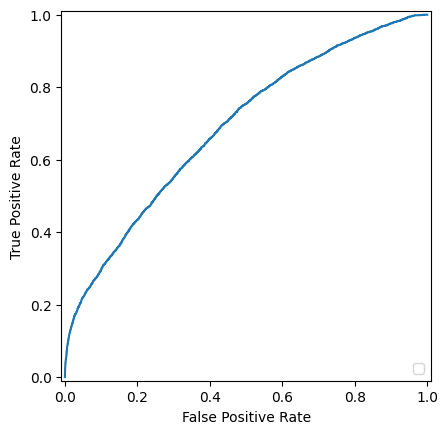

In [20]:
### С изображением рок-кривой для ЛогРега не будет проблем:
### Your code is here

fpr, tpr, thresholds = roc_curve(y_test, pipe_lr.predict_proba(X_test)[:, 1])

from sklearn.metrics import RocCurveDisplay

RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

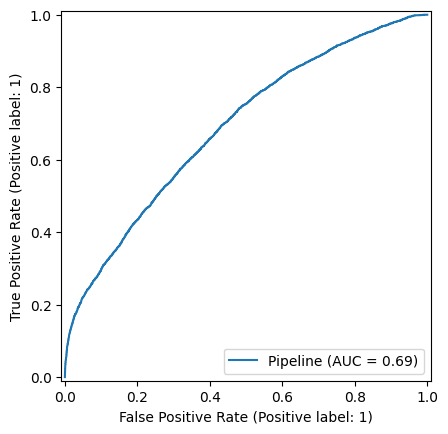

In [21]:
RocCurveDisplay.from_estimator(pipe_lr, X_test, y_test)

In [22]:
### Your code is here
svm_outputs = pipe_svm.decision_function(X_test)

# функция пропорционального преобразования выходов в вероятности
def proportional_transform(outputs):
    min_val = np.min(outputs[outputs <= 0])
    max_val = np.max(outputs[outputs >= 0])

    def transform(value):
        if value <= 0:
            return 0.5 * (value - min_val) / (-min_val)
        else:
            return 0.5 + 0.5 * (value) / (max_val)
    
    probabilities = np.array([transform(x) for x in outputs])
    return probabilities


pred_probabilities_svm = proportional_transform(svm_outputs)

print("Probabilities:", pred_probabilities_svm)

Probabilities: [0.34270761 0.30933019 0.28826525 ... 0.2822543  0.32940222 0.27897497]


In [23]:
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, pred_probabilities_svm)

In [24]:
### Посчитаем ROC-AUC для LogReg
from sklearn.metrics import roc_auc_score

print(f"AUC LR: {roc_auc_score(y_test, pipe_lr.predict_proba(X_test)[:, 1]):.3f}")

### Посчитаем ROC-AUC для SVM
print(f"AUC SVM: {roc_auc_score(y_test, pred_probabilities_svm):.3f}")

AUC LR: 0.689
AUC SVM: 0.688


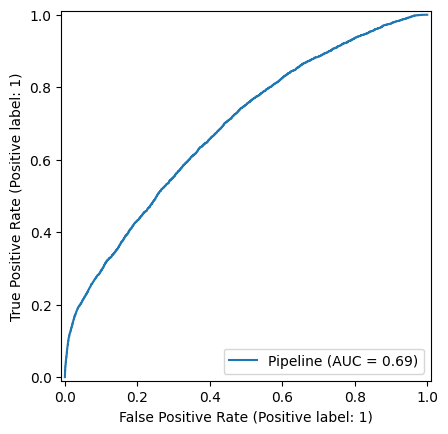

In [25]:
RocCurveDisplay.from_estimator(pipe_svm, X_test, y_test)

Постройте калибровочные кривые для обеих моделей. Методом from_estimator для svm воспользоваться не получится.

In [26]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve


### Your code is here




In [ ]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve


### Your code is here




**Какая калибровочная кривая ближе к диагонали?  Откалибруйте SVM способом как в практике и изобразите новую кривую!

In [ ]:
### Калибровка

from sklearn.calibration import CalibratedClassifierCV

### Your code is here




In [4]:
### Новая кривая

### Your code is here


